<a href="https://colab.research.google.com/github/ZhiyuanYao93/CMPE255/blob/master/CMPE255_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## intentionally left blank

In [0]:
## Section 1: Bootstrap. 
## You need to finish : 
## 1. import necessary packages <---- can be done along the way 
## 2. link to databse. 


## ------ Comment this block if run locally -----###
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
## ----------------  Block ends  --------------#####



## -------Change the 'previous_count' and portion size------------###
##
## This variable is used to compute the previous x games' win ratio, defeat ratio, etc.
previous_count = 15
##
##Portion size: how many entries to use. Since total is 180k which is too much. 
use_partial = True
partial_size = 10000
## ----------------------------###

## import packages 
## Utility tools 
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import itertools
## Models 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline

## Analysis tools 
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, make_scorer
from sklearn import model_selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## 
import warnings
warnings.simplefilter("ignore")


## set up database connection 
path = "/content/drive/My Drive/Colab Notebooks/" # change path here 
database = path + "database.sqlite"; # Adjust databse file name if needed
conn = sqlite3.connect(database)

## Player-related tables 
player_profile_info = pd.read_sql("SELECT * FROM Player;", conn)
player_attributes = pd.read_sql("SELECT * FROM Player_Attributes;", conn)

## Team related tables 
team_profile_info = pd.read_sql("SELECT * FROM Team;", conn)
team_attributes = pd.read_sql("SELECT * FROM Team_Attributes;", conn)

## Match info table 
match_info = pd.read_sql("SELECT * FROM Match;", conn)

Mounted at /content/drive


In [0]:
## Section 2: Feature extraction 
## A list of functions in this section with predefined sections for work assignment
## Please note that functions should have 
##      a) comments 
##      b) expressive naming convention 
##      c) outputs Pandas Dataframe if needed. 

## FUNCTION 1
## Given a match, determiine the label ['win', 'draw', 'lose'] for the HOME_TEAM.
def create_match_label(match):
    home_team_goals = match['home_team_goal']
    away_team_goals = match['away_team_goal']

    if home_team_goals > away_team_goals:
      return "Win"
    
    if home_team_goals < away_team_goals:
      return "Defeat"

    return "Draw"
    
## FUNCTION 2
## To get the last 'count' matches for 'team'. 
##    matches: set of all matches to search from 
##    date: date time from which to look back on
##    team: a specific team to search on
##    count: specified number of matches to return 
def get_previous_matches(matches, date, team, count = 10):
    all_relevant_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
    previous_matches = all_relevant_matches[(all_relevant_matches['date'] < date)].sort_values(by = 'date', ascending = False)
    return previous_matches.iloc[0:count]
    

## FUNCTION 3
## Return the previous 'count' matches of given 2 teams.
## Default value for 'count' is 10. 
def get_previous_encounters(matches, date, home_team, guest_team, count = 10):
    home_team_previous_matches = get_previous_matches(mathces, date, home_team, count)
    previous_encounters = home_team_previous_matches[(home_team_previous_matches['home_team_api_id'] == guest_team) | (home_team_previous_matches['away_team_api_id'] == guest_team)]
    return previous_encounters

## FUNCTION 4
## Return the sum of goals of 'team' in given 'matches'
def get_total_goals(matches, team):
    home_goals = matches.home_team_goal[matches.home_team_api_id == team].sum()
    away_goals = matches.away_team_goal[matches.away_team_api_id == team].sum()
    return home_goals + away_goals

## FUNCTION 5
## Return the total goals conceided by a 'team' in a set of 'matches'
def get_goals_conceided(matches, team):
    home_conceided = matches.away_team_goal[matches.home_team_api_id == team].sum()
    away_conceided = matches.home_team_goal[matches.away_team_api_id == team].sum()
    return home_conceided + away_conceided; 

## FUNCTION 6
## get total number of wins of a 'team' in a set of 'matches'
def get_wins_counts(matches, team):
    home_wins = matches[(matches['home_team_api_id'] == team) & (matches['home_team_goal'] > matches['away_team_goal'])]
    away_wins = matches[(matches['away_team_api_id'] == team) & (matches['away_team_goal'] > matches['home_team_goal'])]
    total_wins = home_wins.shape[0] + away_wins.shape[0]
    return total_wins

## Function 6.1
## (games_won / total_number_of_games) for a 'team' in a set of 'matches'
def get_win_ratio(matches, team):
    total_wins = get_wins_counts(matches, team)
    total_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]

    ## corner case : avoid division by zero exception
    if total_matches.shape[0] == 0:
        return -1

    win_ratio = total_wins / total_matches.shape[0]
    return win_ratio
   
## FUNCTION 7
## get total number of defeats of a 'team' in a set of 'matches'
def get_lost_count(matches, team):
    home_lost = matches[(matches['home_team_api_id'] == team) & (matches['home_team_goal'] < matches['away_team_goal'])]
    away_lost = matches[(matches['away_team_api_id'] == team) & (matches['away_team_goal'] < matches['home_team_goal'])]
    total_lost = home_lost.shape[0] + away_lost.shape[0]
    return total_lost

## Function 7.1
## (number_of_games_lost / total_number_of_games) of a 'team' in a set of 'matches'
def get_lost_ratio(matches, team):
    total_lost = get_lost_count(matches, team)
    total_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]

    ## corner case : avoid division by zero exception 
    if total_matches.shape[0] == 0:
        return -1

    lost_ratio = total_lost / total_matches.shape[0]
    return lost_ratio


# Function 12
# ## Given a player's api id, return its overall rating 
def get_player_rating(player_api_id, date):
    all_ratings = player_attributes[(player_attributes['player_api_id'] == player_api_id)]
    all_ratings = all_ratings[(all_ratings['date'] <= date)].sort_values(by = 'date', ascending = False)
    return all_ratings.iloc[0:1]['overall_rating']
  
## Function 12.1 
def change_player_api_id_to_player_overall_rating(data):
    players = ["home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", 
               "away_player_1", "away_player_2", "away_player_3", "away_player_4", "away_player_5", 
               "away_player_6", "away_player_7", "away_player_8", "away_player_9", "away_player_10",
               "away_player_11"]
    
    num_of_rows = data.shape[0]
    
    for i in range(0, num_of_rows):
        match = data.iloc[i]
        date = match['date']
        for player in players:
            player_api_id = match[player]
            if np.isnan(player_api_id) == True:
                data.at[i, player] = 0
            else:
                 data.at[i, player] = get_player_rating(player_api_id, date)

In [0]:
## Data assembly functions 

## Data needs to include the following columns: 
##        Parameter columns are Column 1 to Column 15. 
##        Label is Column 16. 

## Column 1: match_id

## Column 2: home_team_api_id
## Column 3 -> 13: home_team_player_evaluation_scores
## Column 14: home_team_previous_x_matches_win_ratio
## Column 15: home_team_previous_x_matches_defeat_ratio
## Column 16: home_team_previous_home_game_win_ratio
## Column 17: home_team_previous_home_game_defeat_ratio
## Column 18: home_team_previous_x_opponents_avg_evaluation_score

## Column 19:  guest_team_api_id
## Column 20 -> 30: guest_team_player_evaluation_scores
## Column 31: guest_team_previous_x_matches_win_ratio
## Column 32: guest_team_previous_x_matches_defeat_ratio
## Column 33: guest_team_previous_home_game_win_ratio
## Column 34: guest_team_previous_home_game_defeat_ratio
## Column 35: guest_team_previous_x_opponents_avg_evaluation_score

## Column 36: home_team_result (['win' or 'draw' or 'defeat'] for home_team)

## Assemble all the data needed and feed it to 'Section 3'
def get_home_team_previous_x_match_win_ratio(match):
    match_date = match['date']
    team_id = match['home_team_api_id']
    previous_games = get_previous_matches(match_info, match_date, team_id, previous_count)
    return get_win_ratio(previous_games, team_id)


def get_home_team_previous_x_match_defeat_ratio(match):
    match_date = match['date']
    team_id = match['home_team_api_id']
    previous_games = get_previous_matches(match_info, match_date, team_id, previous_count)
    return get_lost_ratio(previous_games, team_id)


def get_away_team_previous_x_match_win_ratio(match):
    match_date = match['date']
    team_id = match['away_team_api_id']
    previous_games = get_previous_matches(match_info, match_date, team_id, previous_count)
    return get_win_ratio(previous_games, team_id)


def get_away_team_previous_x_match_defeat_ratio(match):
    match_date = match['date']
    team_id = match['away_team_api_id']
    previous_games = get_previous_matches(match_info, match_date, team_id, previous_count)
    return get_lost_ratio(previous_games, team_id)
    
def get_previous_home_games(matches, match, team_id, count = 10):
    all_relevant_matches = matches[(matches['home_team_api_id'] == team_id)]
    date = match['date']
    previous_home_matches = all_relevant_matches[(all_relevant_matches['date'] < date)].sort_values(by = 'date', ascending = False)
    return previous_home_matches.iloc[0:count]

def get_previous_away_games(matches, match, team_id, count = 10):
    all_relevant_matches = matches[(matches['away_team_api_id'] == team_id)]
    date = match['date']
    previous_away_matches = all_relevant_matches[(all_relevant_matches['date'] < date)].sort_values(by = 'date', ascending = False)
    return previous_away_matches.iloc[0:count]
    
def get_home_team_previous_x_home_game_win_ratio(match):
    team_id = match['home_team_api_id']
    previous_home_games = get_previous_home_games(match_info, match, team_id, previous_count)
    return get_win_ratio(previous_home_games, team_id)

def get_home_team_previous_x_home_game_defeat_ratio(match):
    team_id = match['home_team_api_id']
    previous_home_games = get_previous_home_games(match_info, match, team_id, previous_count)
    return get_lost_ratio(previous_home_games, team_id)
    
def get_guest_team_previous_x_away_game_win_ratio(match):
    team_id = match['away_team_api_id']
    previous_away_games = get_previous_away_games(match_info, match, team_id, previous_count)
    return get_win_ratio(previous_away_games, team_id)
    
def get_guest_team_previous_x_away_game_defeat_ratio(match):
    team_id = match['away_team_api_id']
    previous_away_games = get_previous_away_games(match_info, match, team_id, previous_count)
    return get_lost_ratio(previous_away_games, team_id)

def get_necessary_data(num_of_entries):
    attributes_from_match_info = ['stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 
                              'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
                             'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9','home_player_10',
                             'home_player_11', 
                             'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
                             'away_player_6', 'away_player_7', 'away_player_8','away_player_9','away_player_10', 
                             'away_player_11']

    data = match_info[attributes_from_match_info].head(num_of_entries)
    data['home_team_previous_win_ratios'] = data.apply(get_home_team_previous_x_match_win_ratio, axis = 1)
    data['home_team_previous_defeat_ratio'] = data.apply(get_home_team_previous_x_match_defeat_ratio, axis = 1)
    data['home_team_previous_home_games_win_ratio'] = data.apply(get_home_team_previous_x_home_game_win_ratio,axis = 1)
    data ['home_team_previous_home_games_defeat_ratio'] = data.apply(get_home_team_previous_x_home_game_defeat_ratio,axis = 1)

    data['away_team_previous_win_ratios'] = data.apply(get_away_team_previous_x_match_win_ratio, axis = 1)
    data['away_team_previous_defeat_ratio'] = data.apply(get_away_team_previous_x_match_defeat_ratio, axis = 1)
    data['away_team_previous_away_games_win_ratio'] = data.apply(get_guest_team_previous_x_away_game_win_ratio,axis = 1)
    data ['away_team_previous_away_games_defeat_ratio'] = data.apply(get_guest_team_previous_x_away_game_defeat_ratio,axis = 1)

    data['label'] = data.apply(create_match_label, axis = 1)

    change_player_api_id_to_player_overall_rating(data)
    return data; 

In [0]:
## Section 3: Main section that includes 
## 0. creating models. 
## 1. splitting data, 
## 2. training 
## 3. testing 
## 4. tunning 
## 5. conclusions 

## Start main section below: 
number_of_entries = match_info.shape[0]

## ---------- Note here only the first 30 entries are extracted. Change the paramter to adjust the number of entries -----------#####
if use_partial:
  data = get_necessary_data(partial_size)
else:
  data = get_necessary_data(number_of_entries)

data = data.drop(['stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id'], axis=1)

number_of_features = data.shape[1] - 1
feature_column_indices = list(range(0, number_of_features))

label_index = data.shape[1] - 1

features = data.iloc[:, feature_column_indices]

labels = data.iloc[:, label_index]

# features.head()

In [0]:


#Splitting the data into Train and Test data sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)


## Initializing all models and parameters
#Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
MLP_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
KNN_clf = KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
GNB_clf = GaussianNB()
SVM_clf = svm.SVC(gamma='scale', probability=True)
clfs = [RF_clf, AB_clf, MLP_clf, KNN_clf, LOG_clf, GNB_clf, SVM_clf]

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 
                 'pca__n_components': [5, 10, 15]}
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5), 
                 'pca__n_components': [5, 10, 15]}
parameters_MLP = {'pca__n_components': [5, 10, 15]}
parameters_KNN = {'clf__n_neighbors': [3, 5, 10], 
                  'pca__n_components': [5, 10, 15]}
parameters_LOG = {'clf__C': np.logspace(1, 1000, 5), 
                  'pca__n_components': [5, 10, 15]}
parameters_GNB = {'pca__n_components': [5, 10, 15]}
parameters_SVM = {'pca__n_components': [5, 10, 15]}

parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_MLP,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG,
              clfs[5]: parameters_GNB,
              clfs[6]: parameters_SVM}

#Initializing PCA
pca = PCA()

#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)

#Initialize result storage
clfs_return = []
dm_reduce_return = []
train_scores = []
test_scores = []

#Loop through classifiers
for clf in clfs:

    estimators = [('pca', pca), ('clf', clf)]
    pipeline = Pipeline(estimators)
    
    print("Training a {} with {}...".format(clf.__class__.__name__, pca.__class__.__name__))
    start = time()
    
    #Grid search over pipeline and return best classifier
    grid = model_selection.GridSearchCV(pipeline, param_grid = parameters[clf], scoring = scorer, cv = cv_sets, n_jobs = 1)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    #clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['pca'].transform(X_train), y_train)
    dm_reduce = best_pipe.named_steps['pca']
    
    end = time()
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Make predictions of train data
    y_train_pred = clf.predict(best_pipe.named_steps['pca'].transform(X_train))
    train_score = accuracy_score(y_train.values, y_train_pred)
    print("Score of {} for train set: {:.4f}.".format(clf.__class__.__name__, train_score))
    
    #Make predictions of test data
    y_test_pred = clf.predict(best_pipe.named_steps['pca'].transform(X_test))
    test_score = accuracy_score(y_test.values, y_test_pred)
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, test_score))
    
    #Append the result to storage            
    clfs_return.append(clf)
    dm_reduce_return.append(dm_reduce)
    train_scores.append(train_score)
    test_scores.append(test_score)

Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 2.3 minutes
Score of RandomForestClassifier for train set: 1.0000.
Score of RandomForestClassifier for test set: 0.5025.
Training a AdaBoostClassifier with PCA...
Trained AdaBoostClassifier in 4.5 minutes
Score of AdaBoostClassifier for train set: 0.5292.
Score of AdaBoostClassifier for test set: 0.5245.
Training a MLPClassifier with PCA...
Trained MLPClassifier in 0.3 minutes
Score of MLPClassifier for train set: 0.5094.
Score of MLPClassifier for test set: 0.5175.
Training a KNeighborsClassifier with PCA...
Trained KNeighborsClassifier in 0.2 minutes
Score of KNeighborsClassifier for train set: 0.6195.
Score of KNeighborsClassifier for test set: 0.4360.
Training a LogisticRegression with PCA...
Trained LogisticRegression in 0.3 minutes
Score of LogisticRegression for train set: 0.4795.
Score of LogisticRegression for test set: 0.4915.
Training a GaussianNB with PCA...
Trained GaussianNB in 0.0 minutes
Sco

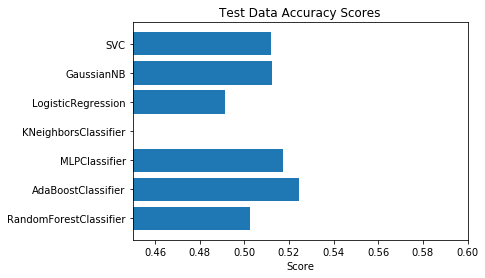

In [0]:
def plot_test_result(clfs, test_score):
    names = []
    for i in range(0, len(clfs)): 
        clf = clfs[i]
        clf_name = clf.__class__.__name__
        names.append(clf_name)

    y_pos = np.arange(len(names))

    plt.barh(y_pos, test_scores, align='center')
    plt.yticks(y_pos, names)
    plt.xlim(0.45, 0.6)
    plt.xlabel('Score')
    plt.title('Test Data Accuracy Scores')

    plt.show()
plot_test_result(clfs, test_score)

In [0]:
#Defining the best classifier
best_clf = clfs_return[np.argmax(test_scores)]
best_dm_reduce = dm_reduce_return[np.argmax(test_scores)]

print("The best classifier is {}".format(best_clf.__class__.__name__))

#Define label names and get confusion matrix values
result_label = ["Win", "Draw", "Defeat"]
y_test_pred = best_clf.predict(best_dm_reduce.transform(X_test))
cm = confusion_matrix(y_test, y_test_pred, result_label)
cm = cm.astype('float') / cm.sum()
#print(cm)

The best classifier is AdaBoostClassifier


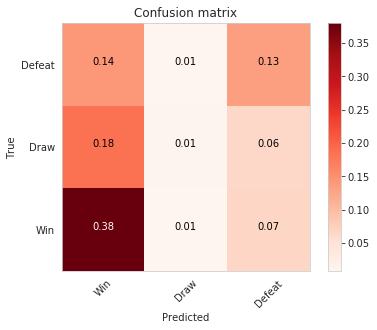

Test score of the best classifier is 0.5245
              precision    recall  f1-score   support

      Defeat       0.50      0.47      0.49       569
        Draw       0.38      0.04      0.07       521
         Win       0.54      0.84      0.65       910

    accuracy                           0.52      2000
   macro avg       0.47      0.45      0.40      2000
weighted avg       0.49      0.52      0.46      2000



In [0]:
# Plot confusion matrix
def plot_confusion_matrix(cm): 
    labels = ["Win", "Draw", "Defeat"]
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Reds) 
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlim()
    plt.ylim(-0.5,2.5)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
    plt.show()
plot_confusion_matrix(cm)
print("Test score of the best classifier is {:.4f}".format(np.max(test_scores)))
print(classification_report(y_test, y_test_pred))

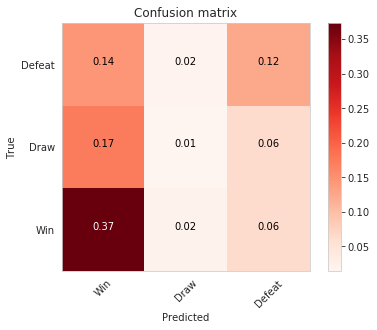

Bookkeeper score for test set: 0.5122.
              precision    recall  f1-score   support

      Defeat       0.49      0.43      0.46     55088
        Draw       0.27      0.06      0.09     48609
         Win       0.54      0.81      0.65     88187

    accuracy                           0.51    191884
   macro avg       0.43      0.43      0.40    191884
weighted avg       0.46      0.51      0.45    191884



In [0]:
def convert_odds_to_prob(match_odds):
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs

def get_bookkeeper_data(matches):

    bookkeepers = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
    
    bk_data = pd.DataFrame()
    
    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        
        #Aggregate vertically
        bk_data = bk_data.append(temp_data, ignore_index = True)
    
    #Return bookkeeper data
    return bk_data

def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    #Return label        
    return label.loc[0]

#Get match labels
y_test_bk = match_info.apply(get_match_label, axis = 1)

#Get bookkeeper data
data = get_bookkeeper_data(match_info)

#Convert odds to probabilities
bookkeeper_probs = convert_odds_to_prob(data)

bookkeeper_probs.reset_index(inplace = True, drop = True)
bookkeeper_probs.dropna(inplace = True)

#Get bookkeeper labels
y_pred_bk = pd.DataFrame()
y_pred_bk.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis = 1)
y_pred_bk.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']

#Format data
results = pd.merge(y_pred_bk, y_test_bk, on = 'match_api_id', how = 'left')
y_test = results.loc[:, 'label']
y_pred = results.loc[:, 'bk_label']

#Generate confusion matrix
labels = ["Win", "Draw", "Defeat"]
cm_bk = confusion_matrix(y_test, y_pred, labels) 
cm_bk = cm_bk.astype('float') / cm_bk.sum()
plot_confusion_matrix(cm_bk)

print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred)) 

In [0]:
# Predict probabilities of matches
predict_result_probability = best_clf.predict_proba(best_dm_reduce.transform(X_test))
predict_result_probability

array([[0.33511397, 0.33352492, 0.33136111],
       [0.33355346, 0.33497451, 0.33147203],
       [0.33259599, 0.33303604, 0.33436798],
       ...,
       [0.33156171, 0.33338853, 0.33504976],
       [0.33339229, 0.33299377, 0.33361393],
       [0.33328452, 0.33319484, 0.33352064]])